# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Variable Renewable Energy (VRE) assessment and forecast

### Project objectives
<div class="alert alert-block alert-info">

- Assess the onshore wind or solar photovoltaic hourly production over in metropolitan France regions using climate data and capacity factor observations.
- Predict the VRE power ahead of time.
</div>

### Dataset

- Observed monthly VRE capacity factors averaged over metropolitan France regions from 2014 to 2021
- Climate variables of your choice from a global reanalysis with an hourly sampling from 2010 to 2019

### First steps

- Choose from solar or wind power
- Read about solar/wind production assessment and forecast
- Estimate the hourly solar/wind production

### Reading the data

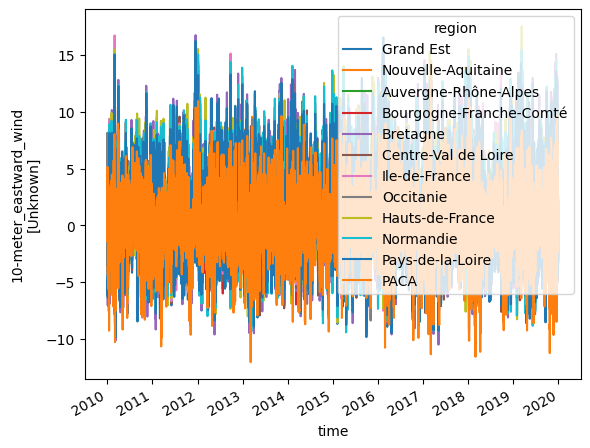

<Figure size 640x480 with 0 Axes>

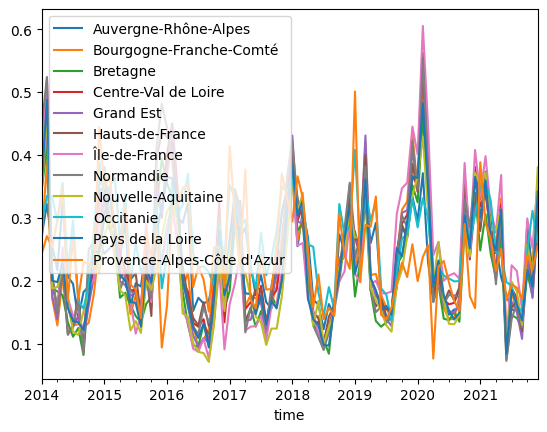

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Directories where you saved the data
data_dir_energy = Path('data/projects/energy_france')
data_dir_climate = Path('data/projects/climate_france')
                        
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
filename_energy = 'reseaux_energies_{}.csv'

# Read and plot grid point-region mask
filepath_mask = Path(data_dir_climate, filename_mask)   
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']
#plt.figure()
#plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')

# Read a climate variable and plot its mean over time
variable_name = 'zonal_wind'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_climate = xr.load_dataset(filepath)[variable_name]
#plt.figure()
#plt.scatter(da_mask['lon'], da_mask['lat'], c=da_climate.mean('time'))

# Compute regional mean of climate variable and plot time series
da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
da_climate_reg['region'] = ds_mask['region'].values
plt.figure()
da_climate_reg.plot.line(x='time')

# Read energy variable and plot time series
variable_name = 'capacityfactor_wind-onshore'
filename = filename_energy.format(variable_name)
filepath = Path(data_dir_energy, filename)
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot()

### Selecting a location in metropolitan France and accessing climate variables of this location

In [ ]:
ds_mask = xr.load_dataset(data_dir_climate / filename_mask)
da_mask = ds_mask['mask']

variables = [
    'zonal_wind',
    'meridional_wind',
    'surface_temperature',
    'surface_downward_radiation',
    'surface_density',
    'surface_specific_humidity',
    'upper_zonal_wind',
    'upper_meridional_wind',
    'height_500',
]

region_name = 'Ile-de-France'

In [62]:
da_climate_reg.region.values

array(['Grand Est', 'Nouvelle-Aquitaine', 'Auvergne-Rhône-Alpes',
       'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
       'Ile-de-France', 'Occitanie', 'Hauts-de-France', 'Normandie',
       'Pays-de-la-Loire', 'PACA'], dtype=object)

In [63]:
dfs = []

for var in variables:
    ds_var = xr.load_dataset(data_dir_climate / filename_climate.format(var))
    da_var = ds_var[var]                               # (time, lat, lon)

    da_var_reg = da_var.groupby(da_mask).mean().rename(mask='region')
    da_var_reg['region'] = ds_mask['region'].values    # same as prof

    # select region, convert to pandas Series, rename with variable name
    series_region = da_var_reg.sel(region=region_name).to_pandas()
    dfs.append(series_region.rename(var))

# Combine all variables side by side
df_all_variables = pd.concat(dfs, axis=1)

df_all_variables.head()


,zonal_wind,meridional_wind,surface_temperature,surface_downward_radiation,surface_density,surface_specific_humidity,upper_zonal_wind,upper_meridional_wind,height_500
time,,,,,,,,,
2010-01-01 00:00:00,-1.468698,-4.666749,270.874664,0.0,1.257525,0.003166,-2.006901,-6.064606,5295.040527
2010-01-01 01:00:00,-1.377419,-4.844347,270.669556,0.0,1.258333,0.003114,-1.873307,-6.256418,5291.553223
2010-01-01 02:00:00,-1.197237,-4.951035,270.530884,0.0,1.259004,0.003071,-1.647632,-6.365789,5288.624512
2010-01-01 03:00:00,-0.947237,-5.157548,270.488617,0.0,1.259318,0.003047,-1.308583,-6.573075,5285.341309
2010-01-01 04:00:00,-0.523589,-5.287978,270.503052,0.0,1.259582,0.003038,-0.793256,-6.811546,5282.789551


In [64]:
df_energy['Île-de-France'].head()

time
2014-01-01    0.397
2014-02-01    0.523
2014-03-01    0.208
2014-04-01    0.152
2014-05-01    0.253
Name: Île-de-France, dtype: float64

In [ ]:
df_climate_monthly = df_all_variables.resample('MS').mean()
df_climate_monthly

In [81]:
df_climate_overlap = df_climate_monthly.loc['2014-01-01':'2019-12-01']
cf_overlap = df_energy['Île-de-France'].loc['2014-01-01':'2019-12-01']
cf_overlap = cf_overlap.rename('capacity_factor')

In [69]:
df_climate_overlap

,zonal_wind,meridional_wind,surface_temperature,surface_downward_radiation,surface_density,surface_specific_humidity,upper_zonal_wind,upper_meridional_wind,height_500
time,,,,,,,,,
2014-01-01,1.457212,3.932577,278.326843,35.078514,1.239541,0.005184,2.201479,5.413025,5441.876465
2014-02-01,2.368809,4.987933,278.731354,66.375504,1.236099,0.004937,3.462634,6.872248,5407.690918
2014-03-01,0.433149,0.747019,281.533936,150.002029,1.237386,0.004942,0.462770,1.120855,5576.235352
2014-04-01,0.240969,0.179756,284.320435,203.017075,1.222223,0.006059,0.329754,0.195392,5591.039062
2014-05-01,1.160403,0.544363,285.875427,242.731064,1.216665,0.006797,1.622033,0.683228,5610.685547
...,...,...,...,...,...,...,...,...,...
2019-08-01,1.408895,0.461117,293.096375,228.612228,1.186036,0.008507,1.932217,0.466144,5764.394531
2019-09-01,1.105618,-0.042446,289.145721,190.179108,1.206204,0.007319,1.497324,-0.181627,5749.764648
2019-10-01,1.522698,1.881359,285.335632,93.818886,1.215386,0.007387,2.270087,2.770181,5654.728027


In [82]:
cf_overlap

time
2014-01-01    0.397
2014-02-01    0.523
2014-03-01    0.208
2014-04-01    0.152
2014-05-01    0.253
              ...  
2019-08-01    0.183
2019-09-01    0.306
2019-10-01    0.347
2019-11-01    0.356
2019-12-01    0.445
Name: capacity_factor, Length: 72, dtype: float64

In [79]:
df_dataset = df_climate_overlap.copy()
df_dataset['capacity_factor'] = cf_overlap
df_dataset = df_climate_overlap.join(cf_overlap, how='inner')


In [80]:
df_dataset.head()

,zonal_wind,meridional_wind,surface_temperature,surface_downward_radiation,surface_density,surface_specific_humidity,upper_zonal_wind,upper_meridional_wind,height_500,capacity_factor
time,,,,,,,,,,
2014-01-01,1.457212,3.932577,278.326843,35.078514,1.239541,0.005184,2.201479,5.413025,5441.876465,0.397
2014-02-01,2.368809,4.987933,278.731354,66.375504,1.236099,0.004937,3.462634,6.872248,5407.690918,0.523
2014-03-01,0.433149,0.747019,281.533936,150.002029,1.237386,0.004942,0.462770,1.120855,5576.235352,0.208
2014-04-01,0.240969,0.179756,284.320435,203.017075,1.222223,0.006059,0.329754,0.195392,5591.039062,0.152
2014-05-01,1.160403,0.544363,285.875427,242.731064,1.216665,0.006797,1.622033,0.683228,5610.685547,0.253


In [83]:
df_dataset_norm = df_dataset / df_dataset.std()
df_dataset_norm

,zonal_wind,meridional_wind,surface_temperature,surface_downward_radiation,surface_density,surface_specific_humidity,upper_zonal_wind,upper_meridional_wind,height_500,capacity_factor
time,,,,,,,,,,
2014-01-01,1.287963,2.704674,47.231089,0.394516,46.048931,2.804576,1.332637,2.603380,49.450816,4.311815
2014-02-01,2.093680,3.430506,47.299733,0.746503,45.921045,2.671027,2.096060,3.305189,49.140169,5.680300
2014-03-01,0.382840,0.513771,47.775321,1.687023,45.968848,2.673464,0.280132,0.539072,50.671747,2.259087
2014-04-01,0.212981,0.123629,48.248180,2.283266,45.405541,3.278064,0.199612,0.093973,50.806270,1.650871
2014-05-01,1.025627,0.374391,48.512057,2.729916,45.199060,3.677236,0.981876,0.328597,50.984799,2.747831
...,...,...,...,...,...,...,...,...,...,...
2019-08-01,1.245257,0.317138,49.737426,2.571126,44.061201,4.602394,1.169642,0.224191,52.381567,1.987562
2019-09-01,0.977204,-0.029192,49.067014,2.138882,44.810453,3.959512,0.906385,-0.087353,52.248623,3.323464
2019-10-01,1.345842,1.293926,48.420456,1.055150,45.151563,3.996644,1.374167,1.332311,51.385017,3.768765


#### Correlation matrix - linear dependency -> take out variables?
#### Reach-le saux method to analyse relation between the variables -> penalization methods, using all variables
#### Feature importance -> after model implemented -> which is the importance of each variable to the model
### 

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>